In [1]:
import os
import re
import glob
import pickle
import itertools

from collections import defaultdict

import pandas as pd
import numpy as np
import scipy as sp
import cupy as cp
import cusignal

import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'png'

import tqdm
import mne

from bids import BIDSLayout
from statsmodels.stats.multitest import multipletests
from joblib import Parallel, delayed
from skimage import measure

from crosspy.preprocessing.seeg.support import clean_montage, drop_monopolar_channels
from crosspy.preprocessing.seeg.seeg_utils import create_reference_mask, get_electrode_distance
from crosspy.preprocessing.signal import preprocess_data_morlet

from ..utils.ripples_utils import is_monopolar, baseline_zscore, create_task_masks, make_bipolar



/home/vladka/anaconda3/envs/sync_states/lib/python3.6/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}


In [2]:
np.random.seed(42)

In [3]:
def bootstrap_mean(arr, n_rounds=1000):
    res = np.zeros(n_rounds)
    
    for idx in range(n_rounds):
        indices = np.random.randint(0, arr.shape[0], arr.shape[0])
        res[idx] = arr[indices].mean(axis=0))
        
    return res

In [4]:
from matplotlib.colors import LinearSegmentedColormap
cdict1 = {'red':   ((0.0, 0.0, 0.0),
                   (0.166, 0.43, 0.43),
                   (0.33, 0.7, 0.7),
                   (0.5, 1.0, 1.0),
                   (0.66, 0.8, 0.8),
                   (1.0, 0.6, 0.6)),

         'green': ((0.0, 0.4, 0.4),
                   (0.166, 0.7, 0.7),
                   (0.33, 0.8, 0.8),
                   (0.5, 1.0, 1.0),
                   (0.66, 0.8, 0.8),
                   (1.0,0.0, 0.0)),

         'blue':  ((0.0, 0.8, 0.8),
                   (0.166, 1.0, 1.0),
                   (0.33, 1.0, 1.0),
                   (0.5, 0.4, 0.4),
                   (0.66, 0.0, 0.0),
                   (1.0, 0.0, 0.0))
        }

ripples_cmap = LinearSegmentedColormap('ripplescmap', cdict1)
ripples_blue = ripples_cmap(0)
ripples_red = ripples_cmap(0.99)
ripples_orange = ripples_cmap(0.7)

In [5]:
frequencies = np.array(
        [
            110.        , 130.        , 150.        , 170.        ,
            190.        , 210.        , 230.        , 250.        ,
            270.        , 290.        , 310.        , 330.        ,
            350.        , 370.        , 390.        , 410.        ,
            430.        , 450.        
            ])

In [6]:
res_files = glob.glob('derivatives/evoked_plv/sub-??_evoked_plv_surr_ersd.pickle')
print('\n'.join(res_files))

derivatives/evoked_plv/sub-10_evoked_plv_surr_ersd.pickle
derivatives/evoked_plv/sub-08_evoked_plv_surr_ersd.pickle
derivatives/evoked_plv/sub-05_evoked_plv_surr_ersd.pickle
derivatives/evoked_plv/sub-06_evoked_plv_surr_ersd.pickle
derivatives/evoked_plv/sub-11_evoked_plv_surr_ersd.pickle
derivatives/evoked_plv/sub-09_evoked_plv_surr_ersd.pickle
derivatives/evoked_plv/sub-01_evoked_plv_surr_ersd.pickle
derivatives/evoked_plv/sub-04_evoked_plv_surr_ersd.pickle
derivatives/evoked_plv/sub-03_evoked_plv_surr_ersd.pickle


In [7]:
def get_task_indicies(data_dict, method='hga'):
    if method == 'erp':
        erp_effect = np.abs(data_dict['ersd_raw'][:, 600:900]).mean(axis=1)
        return np.repeat(np.argsort(erp_effect)[None, ...], 18, axis=0)
    elif method == 'hga':
        return np.argsort(data_dict['hga_response'], axis=1)
    elif method =='hga_erp':
        erp_effect = np.abs(data_dict['ersd_raw'][:, 600:900]).mean(axis=1)
        erp_effect /= np.abs(erp_effect).max()
        
        res = list()
        
        for i in range(data_dict['hga_response'].shape[0]):
            hga_effect = data_dict['hga_response'][i]
            hga_effect /= np.abs(hga_effect).max()
            effect = hga_effect*erp_effect
            res.append(np.argsort(effect))
        
        return np.array(res)

In [8]:
def create_task_between_mask(idx_x, idx_y, total_chans):
    mask_x = np.zeros(total_chans, dtype=bool)
    mask_y = np.zeros(total_chans, dtype=bool)
    
    mask_x[idx_x] = True
    mask_y[idx_y] = True
    
    res = np.zeros((total_chans, total_chans), dtype=bool)
    
    for i, j in itertools.product(range(total_chans), range(total_chans)):
        res[i,j] = (mask_x[i] and mask_y[j]) or (mask_x[j] and mask_y[i])
    
    return res

def threshold_effect(heatmap, t, fill_na=True, top_k=None):
    pos_mask = (heatmap >= t)
    neg_mask = (heatmap <= -t)
    
    pos_labels, pos_n_clusts = measure.label(pos_mask, return_num=True)
    neg_labels, neg_n_clusts = measure.label(neg_mask, return_num=True)
    
    pos_sizes = list()
    for i in range(1, pos_n_clusts+1):
        pos_sizes.append((pos_labels == i).sum())
        
    neg_sizes = list()
    for i in range(1, neg_n_clusts+1):
        neg_sizes.append((neg_labels == i).sum())
        
    if not(top_k is None):
        pos_cnt = Counter(pos_labels.flatten())
        pos_cnt.pop(0)
        
        neg_cnt = Counter(neg_labels.flatten())
        neg_cnt.pop(0)
        
        pos_top = [k[0] for k in pos_cnt.most_common(top_k)]
        neg_top = [k[0] for k in neg_cnt.most_common(top_k)]
        
        pos_mask = np.in1d(pos_labels, pos_top)
        neg_mask = np.in1d(neg_labels, neg_top)
        
    mask_img = pos_mask.astype(float) + -1*neg_mask.astype(float)
           
    if fill_na:
        mask_img[~(pos_mask | neg_mask)] = np.nan
    
    return mask_img, pos_sizes, neg_sizes

In [10]:
def get_clusters(heatmap, t):
    pos_mask = (heatmap >= t)
    neg_mask = (heatmap <= -t)
    
    pos_labels, pos_n_clusts = measure.label(pos_mask, return_num=True)
    neg_labels, neg_n_clusts = measure.label(neg_mask, return_num=True)
    
    return (pos_mask, pos_labels, pos_n_clusts), (neg_mask, neg_labels, neg_n_clusts)

def measure_clusters(heatmap, t):
    (pos_mask, pos_labels, pos_n_clusts), (neg_mask, neg_labels, neg_n_clusts) = get_clusters(heatmap, t)
    pos_sizes = [(pos_labels == i).sum() for i in range(1, pos_n_clusts + 1)]
    neg_sizes = [(neg_labels == i).sum() for i in range(1, neg_n_clusts + 1)]
    
    return pos_sizes, neg_sizes

def threshold_effect(heatmap, t, fill_na=True, top_k=None):
    (pos_mask, pos_labels, pos_n_clusts), (neg_mask, neg_labels, neg_n_clusts) = get_clusters(heatmap, t)
    
    pos_sizes = [(pos_labels == i).sum() for i in range(1, pos_n_clusts + 1)]
    neg_sizes = [(neg_labels == i).sum() for i in range(1, neg_n_clusts + 1)]
        
    if not(top_k is None):
        pos_cnt = Counter(pos_labels.flatten())
        pos_cnt.pop(0)
        
        neg_cnt = Counter(neg_labels.flatten())
        neg_cnt.pop(0)
        
        pos_top = [k[0] for k in pos_cnt.most_common(top_k)]
        neg_top = [k[0] for k in neg_cnt.most_common(top_k)]
        
        pos_mask = np.in1d(pos_labels, pos_top).reshape(pos_labels.shape)
        neg_mask = np.in1d(neg_labels, neg_top).reshape(pos_labels.shape)

    mask_img = pos_mask.astype(float) + -1*neg_mask.astype(float)
           
    if fill_na:
        mask_img[~(pos_mask | neg_mask)] = np.nan
    
    return mask_img, pos_sizes, neg_sizes

/home/vladka/anaconda3/envs/sync_states/lib/python3.6/site-packages/ipykernel_launcher.py:64: RuntimeWarning: Mean of empty slice.
/home/vladka/anaconda3/envs/sync_states/lib/python3.6/site-packages/numpy/core/_methods.py:154: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/home/vladka/anaconda3/envs/sync_states/lib/python3.6/site-packages/ipykernel_launcher.py:67: RuntimeWarning: Mean of empty slice.


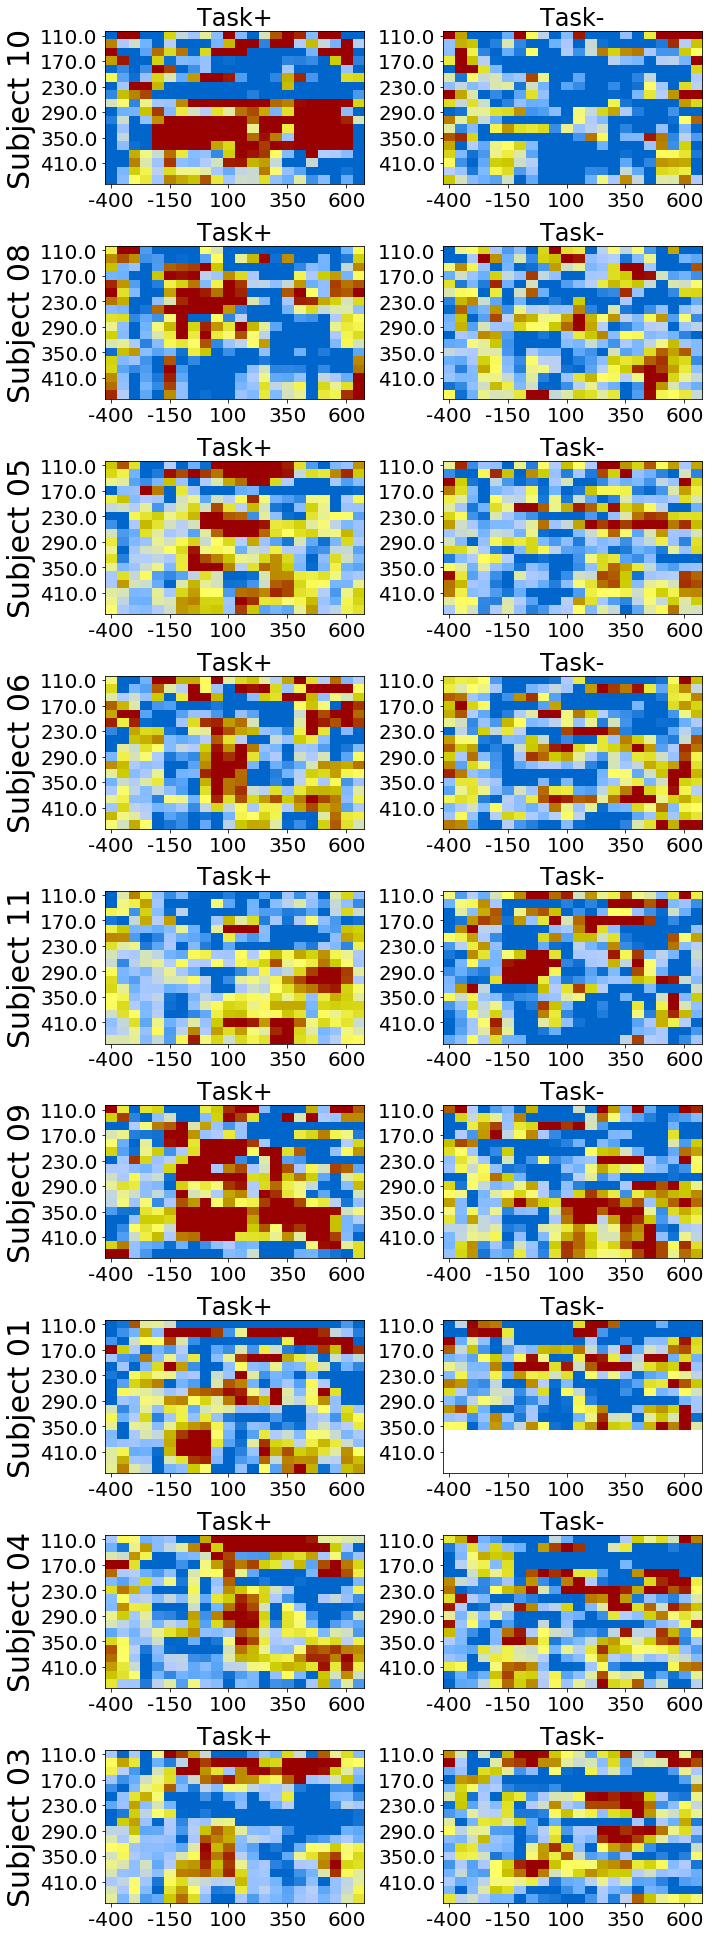

In [11]:
best_frequencies = list()

fig, all_axes = plt.subplots(figsize=(10,3*len(res_files)), ncols=2, nrows=len(res_files))

n_contacts = 5
all_plus_heatmaps = list()

for fname, axes in zip(res_files, all_axes):
    subj_idx = re.findall('\d+', fname)[0]
    
    res_data = pickle.load(open(fname, 'rb'))
    cplv_freqwise = res_data['cplv']
    cplv_surr = res_data['surr_cplv']
    relevance_freqwise = res_data['relevance']
    ref_mask = np.triu(res_data['ref_mask'], 1)
    task_indicies = get_task_indicies(res_data, 'hga')
    
    total_contacts = ref_mask.shape[0]
    n_contacts = max(total_contacts // 20, 5)
    
    task_plus_masks = np.array([create_task_masks(idx[-n_contacts:], task_indicies.shape[1]) for idx in task_indicies])
    task_minus_masks = np.array([create_task_masks(idx[:n_contacts], task_indicies.shape[1]) for idx in task_indicies])
    
    task_masks = task_plus_masks | task_minus_masks
        
    cplv_freqwise_agg = np.array([np.mean(cplv_freqwise[...,i:i+20], axis=3) for i in range(0,110,5)]).transpose(1,2,3,0)
    relevance_freqwise_agg = np.array([np.mean(relevance_freqwise[...,i:i+20], axis=3) for i in range(0,110,5)]).transpose(1,2,3,0)
    cplv_surr_agg = np.array([np.mean(cplv_surr[...,i:i+20], axis=3) for i in range(0,110,5)]).transpose(1,2,3,0)
    
    plv_freqwise_agg = np.abs(cplv_freqwise_agg)
    iplv_freqwise_agg = np.abs(np.imag(cplv_freqwise_agg))

    plv_freqwise_agg -= plv_freqwise_agg[..., :6].mean(axis=-1, keepdims=True)
    iplv_freqwise_agg -= iplv_freqwise_agg[..., :6].mean(axis=-1, keepdims=True)
    
    #surr PLV
    cplv_surr_agg = np.array([np.mean(cplv_surr[...,i:i+20], axis=3) for i in range(0,110,5)]).transpose(1,2,3,0)

    plv_surr_agg = np.abs(cplv_surr_agg)
    iplv_surr_agg = np.abs(np.imag(cplv_surr_agg))

    plv_surr_agg -= plv_surr_agg[..., :6].mean(axis=-1, keepdims=True)
    iplv_surr_agg -= iplv_surr_agg[..., :6].mean(axis=-1, keepdims=True)
    
    plv_surr_agg = np.abs(cplv_surr_agg)
    plv_surr_agg -= plv_surr_agg[..., :6].mean(axis=-1, keepdims=True)
            
    contacts_sorted = np.argsort(relevance_freqwise[:, ref_mask, 50:90].mean(axis=2), axis=1)

    plus_heatmap = np.zeros((18,22))
    minus_heatmap = np.zeros((18,22))
    
    plus_surr = np.zeros((18,22))
    minus_surr = np.zeros((18,22))

    for i in range(18):
        plus_heatmap[i] = plv_freqwise_agg[i, ref_mask & task_plus_masks[i]].mean(axis=0)
        minus_heatmap[i] = plv_freqwise_agg[i, ref_mask & task_minus_masks[i]].mean(axis=0)
        
        plus_surr[i] = plv_surr_agg[i, ref_mask & task_plus_masks[i]].mean(axis=0)
        minus_surr[i] = plv_surr_agg[i, ref_mask & task_minus_masks[i]].mean(axis=0)

    axes[0].imshow(plus_heatmap, cmap=ripples_cmap, aspect='auto', vmin=-0.001, vmax=.002)
    imh = axes[1].imshow(minus_heatmap, cmap=ripples_cmap, aspect='auto', vmin=-0.001, vmax=.002)   
    
    for ax in axes:
        ax.set_xticks(np.arange(22)[::5])
        ax.set_xticklabels(np.arange(-400, 700, 50)[::5])

        ax.set_yticks(np.arange(18)[::3])
        ax.set_yticklabels(frequencies[::3])

        ax.tick_params(labelsize=20)

    axes[0].set_title('Task+', fontsize=24)
    axes[1].set_title('Task-', fontsize=24)
    
    axes[0].set_ylabel('Subject {}'.format(subj_idx), fontsize=30)
    
    if subj_idx == '04':
        to_plot = plus_heatmap
        
    all_plus_heatmaps.append(plus_heatmap)
    
fig.tight_layout()

all_plus_heatmaps = np.array(all_plus_heatmaps)

In [12]:
res_data = pickle.load(open('derivatives/evoked_plv/sub-04_evoked_plv_surr_ersd.pickle', 'rb'))
epochs = mne.read_epochs('data/sub-04_task-gonogo_mon-cw_epo.fif')

epochs.drop_channels([ch for ch in epochs.ch_names if is_monopolar(ch)])
epochs.apply_baseline((None,None))

profile_by_frequency = list()

for freq in frequencies[:11]:
    data_preprocessed = mne.time_frequency.tfr_array_morlet(epochs._data, 1000, [freq], 7.5, n_jobs=32, verbose=False).squeeze()
    data_preprocessed = data_preprocessed[..., 100:-101] #cutoff part of the data to remove filtering artefacts
    
    data_envelope = np.abs(data_preprocessed)
    amp_profile = data_envelope.mean(axis=0)
    amp_profile_zs = baseline_zscore(amp_profile, 400)
    
    profile_by_frequency.append(amp_profile_zs)
    
profile_by_frequency = np.array(profile_by_frequency)
hga_profile = profile_by_frequency.mean(axis=0)
hga_indicies = np.argsort(hga_profile[:, 500:800].mean(axis=1))

task_plus_response = np.array([profile[idx[-5:]] for profile, idx in 
                               zip(profile_by_frequency, res_data['hga_indicies'][:11])]).mean(axis=0)

Reading data/sub-04_task-gonogo_mon-cw_epo.fif ...
    Found the data of interest:
        t =    -500.00 ...    1000.00 ms
        0 CTF compensation matrices available
927 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Applying baseline correction (mode: mean)


In [13]:
all_responses = list()
responses_interp = list()

for fname in res_files:
    res_data = pickle.load(open(fname, 'rb'))
    hga_response = np.sort(res_data['hga_response'].mean(axis=0))
    all_responses.append(hga_response)
    
    nc = hga_response.shape[0]
    hga_interp = np.interp(np.linspace(0, 1, 100), np.arange(nc)/nc, hga_response)
    responses_interp.append(hga_interp)
    
responses_interp = np.array(responses_interp)
all_responses = np.array(all_responses)

# hga_5, hga_95 = np.percentile(responses_interp, (5,95), axis=0)
hga_5, hga_95 = responses_interp.mean(axis=0) - responses_interp.std(axis=0), responses_interp.mean(axis=0) + responses_interp.std(axis=0)

In [16]:
def get_max_clust_surr(plv_surr, ref_mask, task_masks, t, n_rounds=1000, n_clusts=3):
    n_freqs = plv_surr.shape[0]
    
    plv_flatten = plv_surr[:, ref_mask]
    
    boot_max_stat = list()
    
    effects_boot = np.zeros((n_rounds, n_freqs, plv_surr.shape[~0]))
    
    for fidx in range(n_freqs):
        freq_plv = plv_surr[fidx, ref_mask & task_masks[fidx]]

        for i in range(n_rounds):
            idx = np.random.randint(0, freq_plv.shape[0], size=freq_plv.shape[0])
            effects_boot[i, fidx] = freq_plv[idx].mean(axis=0)
    
    boot_stats = list()
    
    for effect in effects_boot:
        pos_clusts, neg_clusts = measure_clusters(effect, t)
        all_clusts = pos_clusts + neg_clusts
        
        if len(all_clusts) < n_clusts:
            all_clusts += [0.]*(n_clusts - len(all_clusts))
        
        max_size = sorted(all_clusts, reverse=True)[:n_clusts]
        boot_stats.append(max_size)
        
    return np.nanpercentile(boot_stats, 95, axis=0)

def get_max_clust_surr_voxel(plv_surr, ref_mask, task_masks, t, n_rounds=1000, n_clusts=3):
    n_freqs = plv_surr.shape[0]
    n_voxels = task_masks.shape[1]
    
    plv_flatten = plv_surr[:, ref_mask]
    
    boot_max_stat = list()
    
    effects_boot = np.zeros((n_rounds, n_voxels, n_freqs, plv_surr.shape[~0]))
    
    for fidx in range(n_freqs):
        for voxel in range(n_voxels):
            freq_plv = plv_surr[fidx, ref_mask & task_masks[fidx, voxel]]

            for i in range(n_rounds):
                idx = np.random.randint(0, freq_plv.shape[0], size=freq_plv.shape[0])
                effects_boot[i, voxel, fidx] = freq_plv[idx].mean(axis=0)
    
    boot_stats = list()
    
    for effect in effects_boot:
        pos_clusts, neg_clusts = measure_clusters(effect.mean(axis=0), t)
        all_clusts = pos_clusts + neg_clusts

        if len(all_clusts) < n_clusts:
            all_clusts += [0.]*(n_clusts - len(all_clusts))
        
        max_size = sorted(all_clusts, reverse=True)[:n_clusts]
        boot_stats.append(max_size)
        
    return np.nanpercentile(boot_stats, 95, axis=0)
        

In [17]:
possible_methods = ['erp', 'hga', 'hga_erp']
t_range = np.linspace(1e-4, 1e-3*8, 100)

In [18]:
results_by_nc = defaultdict(dict)
nc_range = np.array([3,4,5,6,7,8,9,10] + [12,14,16,18,20,22,24,26])
# nc_range = np.arange(0.005, 0.1+0.005, 0.005,)

for contacts_ratio in tqdm.tqdm_notebook(nc_range):
    cohort_surr_by_t = list()
    cohort_plus_by_t = list()
    cohort_minus_by_t = list()

    for fname in tqdm.tqdm_notebook(res_files, leave=False):
        subj_idx = re.findall('\d+', fname)[0]

        res_data = pickle.load(open(fname, 'rb'))
        cplv_freqwise = res_data['cplv']
        cplv_surr = res_data['surr_cplv']
        ref_mask = np.triu(res_data['ref_mask'], 1)
        task_indicies = get_task_indicies(res_data, 'hga')
        
        total_contacts = ref_mask.shape[0]
        n_contacts = int(round(total_contacts / 100 * contacts_ratio))

        task_plus_masks = np.array([create_task_masks(idx[-n_contacts:], task_indicies.shape[1]) for idx in task_indicies])
        task_minus_masks = np.array([create_task_masks(idx[:n_contacts], task_indicies.shape[1]) for idx in task_indicies])
                
        cplv_freqwise_agg = np.array([np.mean(cplv_freqwise[...,i:i+20], axis=3) for i in range(0,110,5)]).transpose(1,2,3,0)
        cplv_surr_agg = np.array([np.mean(cplv_surr[...,i:i+20], axis=3) for i in range(0,110,5)]).transpose(1,2,3,0)

        plv_freqwise_agg = np.abs(cplv_freqwise_agg)
        iplv_freqwise_agg = np.abs(np.imag(cplv_freqwise_agg))

        plv_freqwise_agg -= plv_freqwise_agg[..., :6].mean(axis=-1, keepdims=True)
        iplv_freqwise_agg -= iplv_freqwise_agg[..., :6].mean(axis=-1, keepdims=True)

        #surr PLV
        cplv_surr_agg = np.array([np.mean(cplv_surr[...,i:i+20], axis=3) for i in range(0,110,5)]).transpose(1,2,3,0)

        plv_surr_agg = np.abs(cplv_surr_agg)
        plv_surr_agg -= plv_surr_agg[..., :6].mean(axis=-1, keepdims=True)

        plus_heatmap = np.zeros((18,22))
        plus_surr = np.zeros((18,22))

        for i in range(18):
            plus_heatmap[i] = plv_freqwise_agg[i, ref_mask & task_plus_masks[i]].mean(axis=0)        
            plus_surr[i] = plv_surr_agg[i, ref_mask & task_plus_masks[i]].mean(axis=0)

        surr_by_t = list()
        plus_by_t = list()
        minus_by_t = list()
        
        def _joblib_wrapper_effect(t, n_clusts=3):
            plus_img, plus_pos_clusts, plus_neg_clusts = threshold_effect(plus_heatmap, t)
            surr_lvl = get_max_clust_surr(plv_surr_agg, ref_mask, task_plus_masks, t, n_clusts=n_clusts)
            
            if len(plus_pos_clusts) < n_clusts:
                plus_pos_clusts += [0.]*(n_clusts - len(plus_pos_clusts))
                
            if len(plus_neg_clusts) < n_clusts:
                plus_neg_clusts += [0.]*(n_clusts - len(plus_neg_clusts))
            
            return surr_lvl, sorted(plus_pos_clusts, reverse=True)[:n_clusts], sorted(plus_neg_clusts, reverse=True)[:n_clusts]

        t_results = Parallel(n_jobs=32)(delayed(_joblib_wrapper_effect)(t) 
                                              for t in t_range)
        
        for sbt, pbt, nbt in t_results:
            surr_by_t.append(sbt)
            plus_by_t.append(pbt)
            minus_by_t.append(nbt)
            
        cohort_surr_by_t.append(surr_by_t)
        cohort_plus_by_t.append(plus_by_t)
        cohort_minus_by_t.append(minus_by_t)

    cohort_plus_by_t = np.array(cohort_plus_by_t)
    cohort_minus_by_t = np.array(cohort_minus_by_t)
    cohort_surr_by_t = np.array(cohort_surr_by_t)
    
    results_by_nc[contacts_ratio]['plus'] = cohort_plus_by_t
    results_by_nc[contacts_ratio]['minus'] = cohort_minus_by_t
    results_by_nc[contacts_ratio]['surr'] = cohort_surr_by_t

/home/vladka/anaconda3/envs/sync_states/lib/python3.6/site-packages/ipykernel_launcher.py:44: RuntimeWarning: Mean of empty slice.
/home/vladka/anaconda3/envs/sync_states/lib/python3.6/site-packages/ipykernel_launcher.py:45: RuntimeWarning: Mean of empty slice.


In [19]:
pos_by_subj = np.zeros((9, 16))
neg_by_subj = np.zeros((9, 16))

for subj_idx in range(9):
    subj_results = list()
    for nc in nc_range:
        area_plus = sp.integrate.trapz(results_by_nc[nc]['plus'][subj_idx, :, 1], t_range) - \
                    sp.integrate.trapz(results_by_nc[nc]['surr'][subj_idx, :, 1], t_range)
        
        area_minus = sp.integrate.trapz(results_by_nc[nc]['minus'][subj_idx, :, 1], t_range) - \
                     sp.integrate.trapz(results_by_nc[nc]['surr'][subj_idx, :, 1], t_range)
        subj_results.append((area_plus, area_minus))
    
    pos_areas, neg_areas = list(zip(*subj_results))
    
    pos_by_subj[subj_idx] = pos_areas
    neg_by_subj[subj_idx] = neg_areas
    
pos_nc_boot = bootstrap_mean(pos_by_subj)
neg_nc_boot = bootstrap_mean(neg_by_subj)

p_nc_5, p_nc_95 = np.percentile(pos_by_subj, (5,95), axis=0)
n_nc_5, n_nc_95 = np.percentile(neg_by_subj, (5,95), axis=0)

In [20]:
pos_nc_by_top = list()
neg_nc_by_top = list()

for i in range(3):
    pos_by_subj = np.zeros((9, 16))
    neg_by_subj = np.zeros((9, 16))

    for subj_idx in range(9):
        subj_results = list()
        for nc in nc_range:
            area_plus = sp.integrate.trapz(results_by_nc[nc]['plus'][subj_idx, :, i], t_range) - \
                        sp.integrate.trapz(results_by_nc[nc]['surr'][subj_idx, :, i], t_range)

            area_minus = sp.integrate.trapz(results_by_nc[nc]['minus'][subj_idx, :, i], t_range) - \
                         sp.integrate.trapz(results_by_nc[nc]['surr'][subj_idx, :, i], t_range)
            subj_results.append((area_plus, area_minus))

        pos_areas, neg_areas = list(zip(*subj_results))

        pos_by_subj[subj_idx] = pos_areas
        neg_by_subj[subj_idx] = neg_areas

    pos_nc_boot = bootstrap_mean(pos_by_subj)
    neg_nc_boot = bootstrap_mean(neg_by_subj)
    
    pos_nc_by_top.append(pos_nc_boot)
    neg_nc_by_top.append(neg_nc_boot)

p_nc_5, p_nc_95 = np.percentile(np.sum(pos_nc_by_top, axis=0), (5,95), axis=0)
n_nc_5, n_nc_95 = np.percentile(np.sum(neg_nc_by_top, axis=0), (5,95), axis=0)

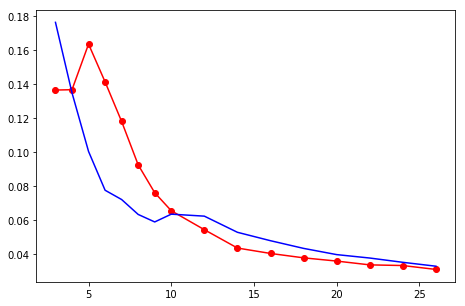

In [21]:
fig, ax = plt.subplots(figsize=(7.5,5))
ax.plot(nc_range, np.sum(pos_nc_by_top, axis=0).mean(axis=0), color='red', marker='o')
ax.plot(nc_range, np.sum(neg_nc_by_top, axis=0).mean(axis=0), color='blue')

In [22]:
results_by_method = defaultdict(dict)
contacts_ratio=5

for method_name in ['hga']:
    cohort_surr_by_t = list()
    cohort_plus_by_t = list()
    cohort_minus_by_t = list()

    for fname in tqdm.tqdm_notebook(res_files):
        subj_idx = re.findall('\d+', fname)[0]

        res_data = pickle.load(open(fname, 'rb'))
        cplv_freqwise = res_data['cplv']
        cplv_surr = res_data['surr_cplv']
        ref_mask = np.triu(res_data['ref_mask'], 1)
        task_indicies = get_task_indicies(res_data, method_name)
        
        total_contacts = ref_mask.shape[0]
        n_contacts = int(round(total_contacts / 100 * contacts_ratio))

        task_plus_masks = np.array([create_task_masks(idx[-n_contacts:], task_indicies.shape[1]) for idx in task_indicies])
        task_minus_masks = np.array([create_task_masks(idx[:n_contacts], task_indicies.shape[1]) for idx in task_indicies])

        cplv_freqwise_agg = np.array([np.mean(cplv_freqwise[...,i:i+20], axis=3) for i in range(0,110,5)]).transpose(1,2,3,0)
        cplv_surr_agg = np.array([np.mean(cplv_surr[...,i:i+20], axis=3) for i in range(0,110,5)]).transpose(1,2,3,0)

        plv_freqwise_agg = np.abs(cplv_freqwise_agg)
        iplv_freqwise_agg = np.abs(np.imag(cplv_freqwise_agg))

        plv_freqwise_agg -= plv_freqwise_agg[..., :6].mean(axis=-1, keepdims=True)
        iplv_freqwise_agg -= iplv_freqwise_agg[..., :6].mean(axis=-1, keepdims=True)

        #surr PLV
        cplv_surr_agg = np.array([np.mean(cplv_surr[...,i:i+20], axis=3) for i in range(0,110,5)]).transpose(1,2,3,0)

        plv_surr_agg = np.abs(cplv_surr_agg)
        plv_surr_agg -= plv_surr_agg[..., :6].mean(axis=-1, keepdims=True)

        plus_heatmap = np.zeros((18,22))
        plus_surr = np.zeros((18,22))

        for i in range(18):
            plus_heatmap[i] = plv_freqwise_agg[i, ref_mask & task_plus_masks[i]].mean(axis=0)        
            plus_surr[i] = plv_surr_agg[i, ref_mask & task_plus_masks[i]].mean(axis=0)

        surr_by_t = list()
        plus_by_t = list()
        minus_by_t = list()
        
        def _joblib_wrapper_effect(t, n_clusts=3):
            plus_img, plus_pos_clusts, plus_neg_clusts = threshold_effect(plus_heatmap, t)
            surr_lvl = get_max_clust_surr(plv_surr_agg, ref_mask, task_plus_masks, t, n_clusts=n_clusts)
            
            if len(plus_pos_clusts) < n_clusts:
                plus_pos_clusts += [0.]*(n_clusts - len(plus_pos_clusts))
                
            if len(plus_neg_clusts) < n_clusts:
                plus_neg_clusts += [0.]*(n_clusts - len(plus_neg_clusts))
            
            return surr_lvl, sorted(plus_pos_clusts, reverse=True)[:n_clusts], sorted(plus_neg_clusts, reverse=True)[:n_clusts]

        t_results = Parallel(n_jobs=32)(delayed(_joblib_wrapper_effect)(t) 
                                              for t in t_range)
        
        for sbt, pbt, nbt in t_results:
            surr_by_t.append(sbt)
            plus_by_t.append(pbt)
            minus_by_t.append(nbt)
            
        cohort_surr_by_t.append(surr_by_t)
        cohort_plus_by_t.append(plus_by_t)
        cohort_minus_by_t.append(minus_by_t)

    cohort_plus_by_t = np.array(cohort_plus_by_t)
    cohort_minus_by_t = np.array(cohort_minus_by_t)
    cohort_surr_by_t = np.array(cohort_surr_by_t)
    
    results_by_method[method_name]['plus'] = cohort_plus_by_t
    results_by_method[method_name]['minus'] = cohort_minus_by_t
    results_by_method[method_name]['surr'] = cohort_surr_by_t

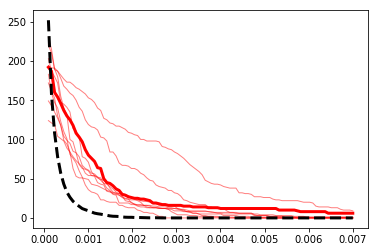

In [23]:
plt.plot(t_range, results_by_method['hga']['plus'].sum(axis=2).T, color='red', lw=1, alpha=0.5)
plt.plot(t_range, results_by_method['hga']['plus'][7].sum(axis=1), color='red', lw=3, label='Positive')
plt.plot(t_range, results_by_method['hga']['surr'].sum(axis=2).mean(axis=0), color='black', ls='--', lw=3, label='Surrogate')

In [24]:
# shifts_num = 28
# shift_range = np.arange(shifts_num)
# shift_with_nc = dict()
# ratio_range = [5]

# for contact_ratio in ratio_range:
#     results_by_shift = defaultdict(dict)
    

#     for shift in tqdm.tqdm_notebook(shift_range):
#         cohort_surr_by_t = list()
#         cohort_plus_by_t = list()
#         cohort_minus_by_t = list()

#         for fname in tqdm.tqdm_notebook(res_files, leave=False):
#             subj_idx = re.findall('\d+', fname)[0]

#             res_data = pickle.load(open(fname, 'rb'))
#             cplv_freqwise = res_data['cplv']
#             cplv_surr = res_data['surr_cplv']
#             ref_mask = np.triu(res_data['ref_mask'], 1)
#             task_indicies = get_task_indicies(res_data, 'hga')

#             total_contacts = ref_mask.shape[0]

#             subj_bin = int(round(total_contacts / 100 * contact_ratio))
#             subj_step = (total_contacts - subj_bin) / shifts_num

#             task_plus_masks = list()
            
#             start = total_contacts - subj_bin - int(round(subj_step*shift))
#             end = start + subj_bin
            
#             for idx in task_indicies:
#                 mask_idx = idx[start:end]
#                 task_plus_masks.append(create_task_masks(mask_idx, task_indicies.shape[1]))

#             task_plus_masks = np.array(task_plus_masks)

#             cplv_freqwise_agg = np.array([np.mean(cplv_freqwise[...,i:i+20], axis=3) for i in range(0,110,5)]).transpose(1,2,3,0)
#             cplv_surr_agg = np.array([np.mean(cplv_surr[...,i:i+20], axis=3) for i in range(0,110,5)]).transpose(1,2,3,0)

#             plv_freqwise_agg = np.abs(cplv_freqwise_agg)
#             iplv_freqwise_agg = np.abs(np.imag(cplv_freqwise_agg))

#             plv_freqwise_agg -= plv_freqwise_agg[..., :5].mean(axis=-1, keepdims=True)
#             iplv_freqwise_agg -= iplv_freqwise_agg[..., :5].mean(axis=-1, keepdims=True)

#             #surr PLV
#             cplv_surr_agg = np.array([np.mean(cplv_surr[...,i:i+20], axis=3) for i in range(0,110,5)]).transpose(1,2,3,0)

#             plv_surr_agg = np.abs(cplv_surr_agg)
#             plv_surr_agg -= plv_surr_agg[..., :5].mean(axis=-1, keepdims=True)

#             plus_heatmap = np.zeros((18,22))
#             plus_surr = np.zeros((18,22))

#             for i in range(18):
#                 plus_heatmap[i] = plv_freqwise_agg[i, ref_mask & task_plus_masks[i]].mean(axis=0)        
#                 plus_surr[i] = plv_surr_agg[i, ref_mask & task_plus_masks[i]].mean(axis=0)

#             surr_by_t = list()
#             plus_by_t = list()
#             minus_by_t = list()

#             def _joblib_wrapper_effect(t, n_clusts=3):
#                 plus_img, plus_pos_clusts, plus_neg_clusts = threshold_effect(plus_heatmap, t)
#                 surr_lvl = get_max_clust_surr_voxel(plv_surr_agg, ref_mask, task_plus_masks, t, n_clusts=n_clusts, n_rounds=100)

#                 if len(plus_pos_clusts) < n_clusts:
#                     plus_pos_clusts += [0.]*(n_clusts - len(plus_pos_clusts))

#                 if len(plus_neg_clusts) < n_clusts:
#                     plus_neg_clusts += [0.]*(n_clusts - len(plus_neg_clusts))

#                 return surr_lvl, sorted(plus_pos_clusts, reverse=True)[:n_clusts], sorted(plus_neg_clusts, reverse=True)[:n_clusts]
            
#             t_results = Parallel(n_jobs=32)(delayed(_joblib_wrapper_effect)(t) 
#                                                   for t in t_range)

#             for sbt, pbt, nbt in t_results:
#                 surr_by_t.append(sbt)
#                 plus_by_t.append(pbt)
#                 minus_by_t.append(nbt)

#             cohort_surr_by_t.append(surr_by_t)
#             cohort_plus_by_t.append(plus_by_t)
#             cohort_minus_by_t.append(minus_by_t)

#         cohort_plus_by_t = np.array(cohort_plus_by_t)
#         cohort_minus_by_t = np.array(cohort_minus_by_t)
#         cohort_surr_by_t = np.array(cohort_surr_by_t)

#         results_by_shift[shift]['plus'] = cohort_plus_by_t
#         results_by_shift[shift]['minus'] = cohort_minus_by_t
#         results_by_shift[shift]['surr'] = cohort_surr_by_t
        
#     shift_with_nc[contact_ratio] = results_by_shift
    
# # pickle.dump(shift_with_nc, open('shift_with_nc_top_3.pickle', 'wb'))

In [25]:
def aggregate_plv(cplv_freqwise):
    cplv_freqwise_agg = np.array([np.mean(cplv_freqwise[...,i:i+20], axis=3) for i in range(0,110,5)]).transpose(1,2,3,0)

    plv_freqwise_agg = np.abs(cplv_freqwise_agg)
    plv_freqwise_agg -= plv_freqwise_agg[..., :5].mean(axis=-1, keepdims=True)
    
    return plv_freqwise_agg

In [26]:
def shuffle_agg_plv(plv_agg, ref_mask):
    res = plv_agg.copy()
    vals_flatten = plv_agg[:, ref_mask]
    
    n_freqs, _, _, n_windows = plv_agg.shape
    
    for i in range(n_freqs):
        for j in range(n_windows):
            np.random.shuffle(vals_flatten[i, :, j])
    
    res[:, ref_mask] = vals_flatten
    
    return res

def _joblib_wrapper_effect(t, heatmap, plv_surr, task_masks, ref_mask, n_clusts=3, n_rounds=100):
        _, plus_pos_clusts, plus_neg_clusts = threshold_effect(heatmap, t)
        surr_lvl = get_max_clust_surr_voxel(plv_surr, ref_mask, task_masks, t, n_clusts=n_clusts, n_rounds=n_rounds)

        if len(plus_pos_clusts) < n_clusts:
            plus_pos_clusts += [0.]*(n_clusts - len(plus_pos_clusts))

        if len(plus_neg_clusts) < n_clusts:
            plus_neg_clusts += [0.]*(n_clusts - len(plus_neg_clusts))

        return surr_lvl, sorted(plus_pos_clusts, reverse=True)[:n_clusts], sorted(plus_neg_clusts, reverse=True)[:n_clusts]

In [27]:
shifts_num = 28
shift_range = np.arange(shifts_num)
ratio_range = [5]

In [28]:
t_range = np.linspace(1e-4, 1e-3*7, 100)

In [29]:
shift_with_nc = dict()
for contact_ratio in ratio_range:
    results_by_shift = defaultdict(dict)

    for shift in tqdm.tqdm_notebook(shift_range):
        cohort_surr_by_t = list()
        cohort_plus_by_t = list()
        cohort_minus_by_t = list()

        for fname in tqdm.tqdm_notebook(res_files, leave=False):
            subj_idx = re.findall('\d+', fname)[0]

            res_data = pickle.load(open(fname, 'rb'))
            cplv_freqwise = res_data['cplv']
            cplv_surr = res_data['surr_cplv']
            ref_mask = np.triu(res_data['ref_mask'], 1)
            task_indicies = get_task_indicies(res_data, 'hga')

            total_contacts = ref_mask.shape[0]

            subj_bin = int(round(total_contacts / 100 * contact_ratio))
            subj_step = (total_contacts - subj_bin) / shifts_num

            task_plus_masks = list()
            
            plv_freqwise_agg = aggregate_plv(cplv_freqwise)
            plv_surr_agg = aggregate_plv(cplv_surr)
            
            plus_heatmap = np.zeros((18,22))
            plus_surr = np.zeros((18,22))
            
            n_voxels = shift*2 + 1 
            
            start = total_contacts - subj_bin - int(round(subj_step*shift))
            end = start + subj_bin
            
            for idx_orig in task_indicies.copy():
                idx = idx_orig
                mask_base = create_task_masks(idx[start:end], task_indicies.shape[1])
                voxel_masks = [mask_base]
                
                for voxel_x in range(max(shift-1, 0), shift):
                    voxel_start = total_contacts - subj_bin - int(round(subj_step*voxel_x))
                    voxel_end = voxel_start + subj_bin
                    voxel_masks.append(create_task_masks(idx[start:end], task_indicies.shape[1], 
                                                         idx[voxel_start:voxel_end]))
                    
                    voxel_masks.append(create_task_masks(idx[voxel_start:voxel_end], task_indicies.shape[1], 
                                                         idx[start:end]))
                
                task_plus_masks.append(voxel_masks)

            task_plus_masks = np.array(task_plus_masks)
            
            surr_by_t = list()
            plus_by_t = list()
            minus_by_t = list()
    

            for i in range(18):
                plus_heatmap[i] = np.nanmean([plv_freqwise_agg[i, ref_mask & task_plus_masks[i,voxel]].mean(axis=0) 
                                              for voxel in range(task_plus_masks.shape[1])], axis=0)
                plus_surr[i] = np.nanmean([plv_surr_agg[i, ref_mask & task_plus_masks[i,voxel]].mean(axis=0) 
                                              for voxel in range(task_plus_masks.shape[1])], axis=0)
            
            t_results = Parallel(n_jobs=32)(delayed(_joblib_wrapper_effect)(t, 
                                                                            plus_heatmap, 
                                                                            plv_surr_agg, 
                                                                            task_plus_masks, 
                                                                            ref_mask,
                                                                            n_rounds=250) 
                                                  for t in t_range)

            for sbt, pbt, nbt in t_results:
                surr_by_t.append(sbt)
                plus_by_t.append(pbt)
                minus_by_t.append(nbt)

            cohort_surr_by_t.append(surr_by_t)
            cohort_plus_by_t.append(plus_by_t)
            cohort_minus_by_t.append(minus_by_t)

        cohort_plus_by_t = np.array(cohort_plus_by_t)
        cohort_minus_by_t = np.array(cohort_minus_by_t)
        cohort_surr_by_t = np.array(cohort_surr_by_t)

        results_by_shift[shift]['plus'] = cohort_plus_by_t
        results_by_shift[shift]['minus'] = cohort_minus_by_t
        results_by_shift[shift]['surr'] = cohort_surr_by_t
        
    shift_with_nc[contact_ratio] = results_by_shift

/home/vladka/anaconda3/envs/sync_states/lib/python3.6/site-packages/ipykernel_launcher.py:62: RuntimeWarning: Mean of empty slice.
/home/vladka/anaconda3/envs/sync_states/lib/python3.6/site-packages/ipykernel_launcher.py:64: RuntimeWarning: Mean of empty slice.


In [30]:
pos_by_subj_shift = np.zeros((3, 6, 9, 28))
neg_by_subj_shift = np.zeros((3, 6, 9, 28))

for i in range(3):
    for ratio in ratio_range:
        results_by_shift = shift_with_nc[ratio]
        for subj_idx in range(9):
            subj_results = list()
            for nc in list(results_by_shift.keys()):
                area_plus = sp.integrate.trapz(results_by_shift[nc]['plus'][subj_idx, :, i], t_range) - \
                            sp.integrate.trapz(results_by_shift[nc]['surr'][subj_idx, :, i], t_range)

                area_minus = sp.integrate.trapz(results_by_shift[nc]['minus'][subj_idx, :, i], t_range) - \
                             sp.integrate.trapz(results_by_shift[nc]['surr'][subj_idx, :, i], t_range)

                subj_results.append((area_plus, area_minus))

            pos_areas, neg_areas = list(zip(*subj_results))

            pos_by_subj_shift[i, ratio-4, subj_idx] = pos_areas
            neg_by_subj_shift[i, ratio-4, subj_idx] = neg_areas
        
pos_by_subj_shift = pos_by_subj_shift.sum(axis=0)[1:2].mean(axis=0)
neg_by_subj_shift = neg_by_subj_shift.sum(axis=0)[1:2].mean(axis=0)

pos_shift_boot = bootstrap_mean(pos_by_subj_shift)
neg_shift_boot = bootstrap_mean(neg_by_subj_shift)
p_5, p_95 = np.percentile(pos_shift_boot, (5, 95), axis=0)
n_5, n_95 = np.percentile(neg_shift_boot, (5, 95), axis=0)

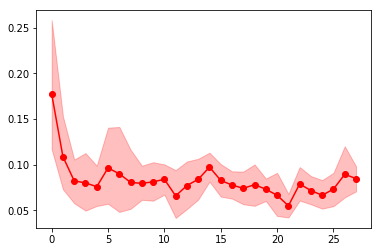

In [31]:
plt.plot(pos_shift_boot.mean(axis=0), color='red', marker='o')
plt.fill_between(np.arange(28), p_5, p_95, color='red', alpha=0.25)

In [32]:
shift_with_nc_shuffled = dict()
n_shufs = 100
for contact_ratio in ratio_range:
    results_by_shift_shuf = defaultdict(dict)
    
    for shift in tqdm.tqdm_notebook(shift_range):
        cohort_surr_by_t = np.zeros((9, 100, 3))
        cohort_plus_by_t = np.zeros((9, n_shufs, 100, 3))
        cohort_minus_by_t = np.zeros((9, n_shufs, 100, 3))

        for subj_idx, fname in enumerate(tqdm.tqdm_notebook(res_files, leave=False)):
            res_data = pickle.load(open(fname, 'rb'))
            cplv_freqwise = res_data['cplv']
            cplv_surr = res_data['surr_cplv']
            ref_mask = np.triu(res_data['ref_mask'], 1)
            task_indicies = get_task_indicies(res_data, 'hga')

            total_contacts = ref_mask.shape[0]

            subj_bin = int(round(total_contacts / 100 * contact_ratio))
            subj_step = (total_contacts - subj_bin) / shifts_num

            task_plus_masks = list()
            
            plv_freqwise_agg = aggregate_plv(cplv_freqwise)
            plv_surr_agg = aggregate_plv(cplv_surr)
                        
            n_voxels = shift*2 + 1 
            
            start = total_contacts - subj_bin - int(round(subj_step*shift))
            end = start + subj_bin
            
            for idx_orig in task_indicies.copy():
                idx = idx_orig
                mask_base = create_task_masks(idx[start:end], task_indicies.shape[1])
                voxel_masks = [mask_base]
                
                for voxel_x in range(max(shift-1, 0), shift):
                    voxel_start = total_contacts - subj_bin - int(round(subj_step*voxel_x))
                    voxel_end = voxel_start + subj_bin
                    voxel_masks.append(create_task_masks(idx[start:end], task_indicies.shape[1], 
                                                         idx[voxel_start:voxel_end]))
                    
                    voxel_masks.append(create_task_masks(idx[voxel_start:voxel_end], task_indicies.shape[1], 
                                                         idx[start:end]))
                
                task_plus_masks.append(voxel_masks)

            task_plus_masks = np.array(task_plus_masks)
            
            def _joblib_wrapper_effect_surr(t, n_clusts=3):
                    return get_max_clust_surr_voxel(plv_surr_agg, ref_mask, task_plus_masks, t, n_clusts=n_clusts, n_rounds=100)
                    
            
            surr_by_t = Parallel(n_jobs=32)(delayed(_joblib_wrapper_effect_surr)(t) for t in t_range)
            cohort_surr_by_t[subj_idx] = surr_by_t
            
            for shuf_idx in range(n_shufs):
                plus_by_t = list()
                minus_by_t = list()
                
                plv_freqwise_agg = shuffle_agg_plv(plv_freqwise_agg, ref_mask)
                plv_surr_agg = shuffle_agg_plv(plv_surr_agg, ref_mask)

                plus_heatmap = np.zeros((18,22))

                for i in range(18):
                    plus_heatmap[i] = np.nanmean([plv_freqwise_agg[i, ref_mask & task_plus_masks[i,voxel]].mean(axis=0) 
                                                  for voxel in range(task_plus_masks.shape[1])], axis=0)


                def _joblib_wrapper_effect_data(t, n_clusts=3):
                    plus_pos_clusts, plus_neg_clusts = measure_clusters(plus_heatmap, t)

                    if len(plus_pos_clusts) < n_clusts:
                        plus_pos_clusts += [0.]*(n_clusts - len(plus_pos_clusts))

                    if len(plus_neg_clusts) < n_clusts:
                        plus_neg_clusts += [0.]*(n_clusts - len(plus_neg_clusts))

                    return sorted(plus_pos_clusts, reverse=True)[:n_clusts], sorted(plus_neg_clusts, reverse=True)[:n_clusts]



                t_results = Parallel(n_jobs=32)(delayed(_joblib_wrapper_effect_data)(t) 
                                                      for t in t_range)

                for pbt, nbt in t_results:
                    plus_by_t.append(pbt)
                    minus_by_t.append(nbt)
                
                cohort_plus_by_t[subj_idx, shuf_idx] = plus_by_t
                cohort_minus_by_t[subj_idx, shuf_idx] = minus_by_t

        results_by_shift_shuf[shift]['plus'] = cohort_plus_by_t
        results_by_shift_shuf[shift]['minus'] = cohort_minus_by_t
        results_by_shift_shuf[shift]['surr'] = cohort_surr_by_t
        
    shift_with_nc_shuffled[contact_ratio] = results_by_shift_shuf
pickle.dump(results_by_shift_shuf, open('shuffled.pickle', 'wb'))
# pickle.dump(shift_with_nc, open('shift_with_nc_top_3.pickle', 'wb'))

/home/vladka/anaconda3/envs/sync_states/lib/python3.6/site-packages/ipykernel_launcher.py:69: RuntimeWarning: Mean of empty slice.


In [54]:
pickle.dump(shift_with_nc, open('shift_with_nc_top_3.pickle', 'wb'))

In [34]:
shifts_num = 28
shift_range = np.arange(shifts_num)
# shift_with_nc = dict()
ratio_range = [5]
# shift_with_nc = pickle.load(open('shift_with_nc_top_3.pickle', 'rb'))

In [35]:
def compute_null_level_mean(results_by_shift):
    pos_by_subj_shift = np.zeros((3, 25, 9, 28))
    neg_by_subj_shift = np.zeros((3, 25, 9, 28))
    
    for i in range(3):
        for subj_idx in range(9):
            for shuf_idx in range(25):
                subj_results = list()
                for nc in list(results_by_shift.keys()):
                    area_plus = sp.integrate.trapz(results_by_shift[nc]['plus'][subj_idx, shuf_idx, :, i], t_range) - \
                                sp.integrate.trapz(results_by_shift[nc]['surr'][subj_idx, :, i], t_range)

                    area_minus = sp.integrate.trapz(results_by_shift[nc]['minus'][subj_idx, shuf_idx, :, i], t_range) - \
                                 sp.integrate.trapz(results_by_shift[nc]['surr'][subj_idx, :, i], t_range)

                    subj_results.append((area_plus, area_minus))

                pos_areas, neg_areas = list(zip(*subj_results))

                pos_by_subj_shift[i, shuf_idx, subj_idx] = pos_areas
                neg_by_subj_shift[i, shuf_idx, subj_idx] = neg_areas
                
    return pos_by_subj_shift.sum(axis=0).mean(axis=(0,1)), neg_by_subj_shift.sum(axis=0).mean(axis=(0,1))

def compute_null_level_max(results_by_shift):
    pos_by_subj_shift = np.zeros((3, 100, 9, 28))
    neg_by_subj_shift = np.zeros((3, 100, 9, 28))
    
    for i in range(3):
        for subj_idx in range(9):
            for shuf_idx in range(100):
                subj_results = list()
                for nc in list(results_by_shift.keys()):
                    area_plus = sp.integrate.trapz(results_by_shift[nc]['plus'][subj_idx, shuf_idx, :, i], t_range) - \
                                sp.integrate.trapz(results_by_shift[nc]['surr'][subj_idx, :, i], t_range)

                    area_minus = sp.integrate.trapz(results_by_shift[nc]['minus'][subj_idx, shuf_idx, :, i], t_range) - \
                                 sp.integrate.trapz(results_by_shift[nc]['surr'][subj_idx, :, i], t_range)

                    subj_results.append((area_plus, area_minus))

                pos_areas, neg_areas = list(zip(*subj_results))

                pos_by_subj_shift[i, shuf_idx, subj_idx] = pos_areas
                neg_by_subj_shift[i, shuf_idx, subj_idx] = neg_areas
    
#     pos_lvl = np.percentile(pos_by_subj_shift.sum(axis=0).mean(axis=(1)), 95)
#     neg_lvl = np.percentile(neg_by_subj_shift.sum(axis=0).mean(axis=(1)), 95)
    pos_lvl_sum = pos_by_subj_shift.sum(axis=0)
    neg_lvl_sum = neg_by_subj_shift.sum(axis=0)
    
#     pos_lvl = np.percentile(pos_lvl, 95, axis=(0,2))
#     neg_lvl = np.percentile(neg_lvl, 95, axis=(0,2))
    
#     return np.percentile(pos_lvl_sum.max(axis=(1,2)), 90), np.percentile(neg_lvl_sum.max(axis=(1,2)), 90)
    return pos_lvl_sum, neg_lvl_sum

In [36]:
pos_lvl_sum, neg_lvl_sum = compute_null_level_max(results_by_shift_shuf)

In [40]:
pos_lvl = np.percentile(pos_lvl_sum.max(axis=(2)), 95, axis=0)
pos_mean = np.percentile(pos_lvl_sum.mean(axis=(2)), 95, axis=0)

neg_lvl = np.percentile(neg_lvl_sum.max(axis=(2)), 95, axis=0)
neg_mean = np.percentile(neg_lvl_sum.mean(axis=(2)), 95, axis=0)



In [41]:
pos_by_subj_shift = np.zeros((3, 6, 9, 28))
neg_by_subj_shift = np.zeros((3, 6, 9, 28))

for i in range(3):
    for ratio in ratio_range:
        results_by_shift = shift_with_nc[ratio]
        for subj_idx in range(9):
            subj_results = list()
            for nc in list(results_by_shift.keys()):
                area_plus = sp.integrate.trapz(results_by_shift[nc]['plus'][subj_idx, :, i], t_range) - \
                            sp.integrate.trapz(results_by_shift[nc]['surr'][subj_idx, :, i], t_range)

                area_minus = sp.integrate.trapz(results_by_shift[nc]['minus'][subj_idx, :, i], t_range) - \
                             sp.integrate.trapz(results_by_shift[nc]['surr'][subj_idx, :, i], t_range)

                subj_results.append((area_plus, area_minus))

            pos_areas, neg_areas = list(zip(*subj_results))

            pos_by_subj_shift[i, ratio-4, subj_idx] = pos_areas
            neg_by_subj_shift[i, ratio-4, subj_idx] = neg_areas
        
pos_by_subj_shift = pos_by_subj_shift.sum(axis=0)[1:2].mean(axis=0)
neg_by_subj_shift = neg_by_subj_shift.sum(axis=0)[1:2].mean(axis=0)

pos_shift_boot = bootstrap_mean(pos_by_subj_shift)
neg_shift_boot = bootstrap_mean(neg_by_subj_shift)
p_5, p_95 = np.percentile(pos_shift_boot, (5, 95), axis=0)
n_5, n_95 = np.percentile(neg_shift_boot, (5, 95), axis=0)

In [42]:
pos_ratio = (pos_by_subj_shift >= pos_lvl[...,None]).mean(axis=0)
neg_ratio = (neg_by_subj_shift >= pos_lvl[...,None]).mean(axis=0)

Text(1, 0.1, 'k=0.4444444444444444')

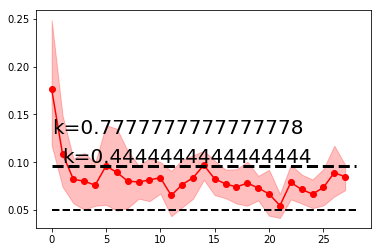

In [44]:
plt.plot(pos_shift_boot.mean(axis=0), color='red', marker='o')
plt.fill_between(np.arange(28), p_5, p_95, color='red', alpha=0.25)
plt.plot([0,28], [pos_lvl.mean(), pos_lvl.mean()], color='black', ls='--', lw=3)
plt.plot([0,28], [pos_mean.mean(), pos_mean.mean()], color='black', ls='--', lw=2)
plt.annotate('k={}'.format(pos_ratio[0]), [0, 0.13], fontsize=20)
plt.annotate('k={}'.format(pos_ratio[1]), [1, 0.10], fontsize=20)

In [45]:
cohort_plus_by_t = results_by_method['hga']['plus']
cohort_minus_by_t = results_by_method['hga']['minus']
cohort_surr_by_t = results_by_method['hga']['surr']

img_to_plot,_,_ = threshold_effect(to_plot, 1e-3)


In [46]:
from collections import Counter
def overlay_multiple_heatmaps(heatmap_list, t):
    pos_overlayed = list()
    neg_overlayed = list()
    
    for effect in heatmap_list:
        effect_img, _ , _ = threshold_effect(effect, t, fill_na=False, top_k=3)
        pos_img = effect_img * (effect_img == 1.)
        neg_img = effect_img * (effect_img == -1.)
        
        pos_overlayed.append(pos_img)
        neg_overlayed.append(neg_img)
        
    pos_overlayed = np.nanmean(pos_overlayed, axis=0)
    neg_overlayed = np.nanmean(neg_overlayed, axis=0)
    
    pos_overlayed[pos_overlayed == 0] = np.nan
    neg_overlayed[neg_overlayed == 0] = np.nan
    
    return pos_overlayed, neg_overlayed

In [ ]:

cohort_plus_by_t = results_by_method['hga']['plus']
cohort_minus_by_t = results_by_method['hga']['minus']
cohort_surr_by_t = results_by_method['hga']['surr']

x_vals_shift = shift_range/140*5

img_to_plot,_,_ = threshold_effect(to_plot, 1e-3, top_k=2)
pos_overlayed, neg_overlayed = overlay_multiple_heatmaps(all_plus_heatmaps, 1e-3)

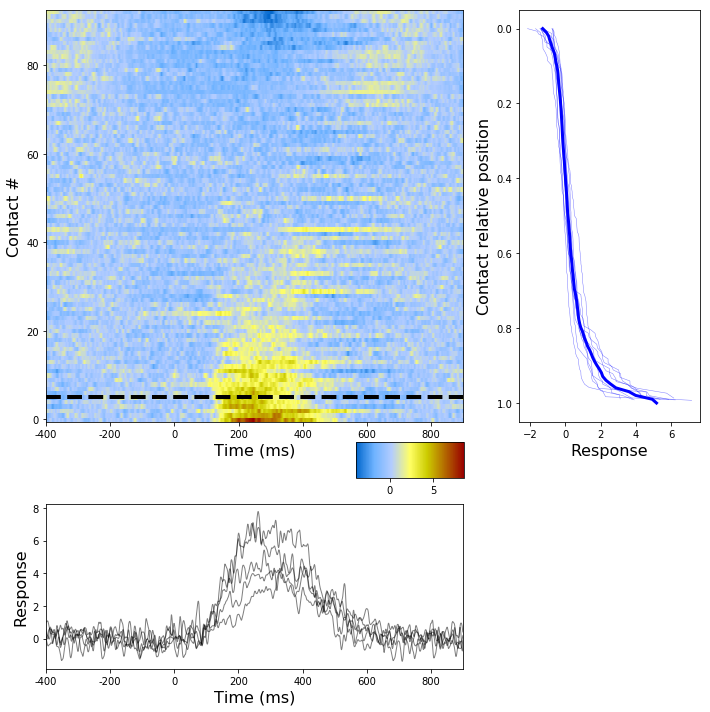

In [56]:
fig = plt.figure(figsize=(10,10))
gs = fig.add_gridspec(3,3)

axes = [fig.add_subplot(gs[:2, :2]), fig.add_subplot(gs[:2,2]), fig.add_subplot(gs[2,:2])]
cax = fig.add_axes([0.5, 0.33, 0.15, 0.05])

imh = axes[0].imshow(hga_profile[hga_indicies[::-1]], origin='lower', cmap=ripples_cmap, aspect='auto')
axes[0].plot([0,1299], [5, 5], ls='--', color='black', lw=4)

_ = axes[2].plot(task_plus_response.T, color='black', alpha=0.5, lw=1)

for resp in all_responses:
    nc = resp.shape[0]
    axes[1].plot(resp, np.arange(nc)/nc, color='blue', lw=0.5, alpha=0.5)
# axes[1].fill_betweenx(np.linspace(0,1,100), hga_5, hga_95, alpha=0.2, color='blue')
axes[1].plot(np.mean(responses_interp, axis=0), np.linspace(0,1,100), color='blue', lw=3)
axes[1].invert_yaxis()
fig.colorbar(imh, cax, orientation='horizontal')

axes[0].set_xlabel('Time (ms)', fontsize=16)
axes[0].set_ylabel('Contact #', fontsize=16)
axes[1].set_xlabel('Response', fontsize=16)
axes[1].set_ylabel('Contact relative position', fontsize=16)
axes[2].set_xlabel('Time (ms)', fontsize=16)
axes[2].set_ylabel('Response', fontsize=16)

axes[0].set_xticks(np.arange(1300)[::200])
axes[0].set_xticklabels(np.arange(-400,900)[::200])

# axes[0].set_yticklabels(np.arange(hga_indicies.shape[0])[::-20])

axes[2].set_xticks(np.arange(1300)[::200])
axes[2].set_xticklabels(np.arange(-400,900)[::200])
axes[2].set_xlim([0,1300])

fig.tight_layout()

plt.subplots_adjust(hspace=0.5)
fig.savefig('evoked_a.pdf', dpi=300)

In [118]:
from matplotlib.colors import ListedColormap

# ripples_with_alpha = ripples_cmap(np.linspace(0,1,100))
# ripples_with_alpha[-50:] = ripples_with_alpha[~0]
# ripples_with_alpha[:50,3] = np.linspace(1,0,50)
# ripples_with_alpha[-50:, 3] = np.linspace(0,1,50)

# my_cmap = ListedColormap(ripples_with_alpha)

red_with_alpha = ripples_cmap(np.linspace(0,1,10))
red_with_alpha[:] = red_with_alpha[~0]
red_with_alpha[:, 3] = np.linspace(0, 1, 10)

red_with_alpha = ListedColormap(red_with_alpha)

blue_with_alpha = ripples_cmap(np.linspace(0,1,10))
blue_with_alpha[:] = blue_with_alpha[0]
blue_with_alpha[:, 3] = np.linspace(0, 1, 10)

blue_with_alpha = ListedColormap(blue_with_alpha)


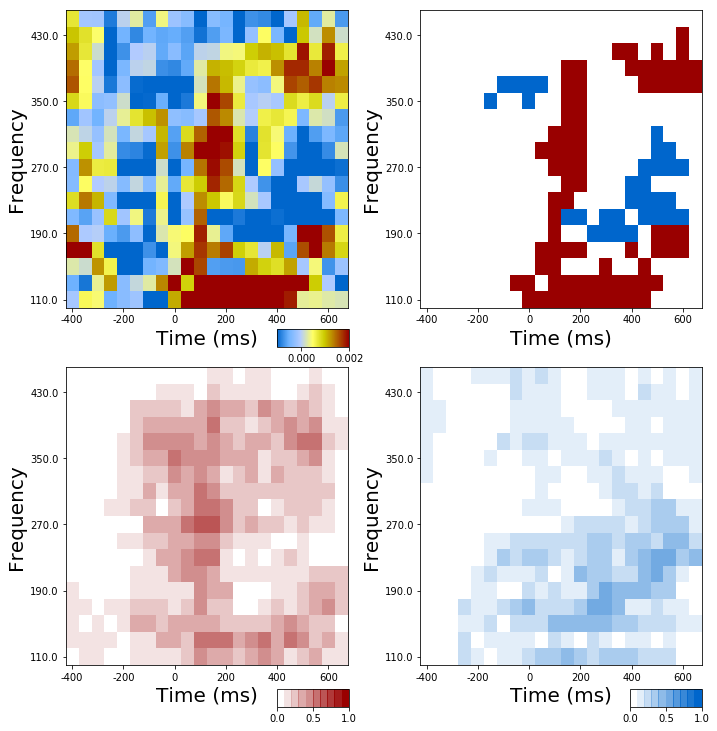

In [119]:
fig, axes = plt.subplots(figsize=(10,10), ncols=2, nrows=2)

imh_00 = axes[0,0].imshow(to_plot, cmap=ripples_cmap, aspect='auto', origin='lower', vmin=-0.001, vmax=0.002)
imh_11 = axes[0,1].imshow(img_to_plot, cmap=ripples_cmap, aspect='auto', origin='lower', vmin=-1, vmax=1)

imh_10 = axes[1,0].imshow(pos_overlayed,  cmap=red_with_alpha, aspect='auto', origin='lower', vmin=0, vmax=1)
imh_11 = axes[1,1].imshow(-neg_overlayed, cmap=blue_with_alpha, aspect='auto', origin='lower', vmin=0, vmax=1)

cax_00 = fig.add_axes([0.39, 0.5125, 0.1, 0.025])
cax_10 = fig.add_axes([0.39, 0.0125, 0.1, 0.025])
cax_11 = fig.add_axes([0.88, 0.0125, 0.1, 0.025])

fig.colorbar(imh_00, cax_00, orientation='horizontal')
fig.colorbar(imh_10, cax_10, orientation='horizontal')
fig.colorbar(imh_11, cax_11, orientation='horizontal')

for ax in axes.flatten():
    ax.set_xticks(np.arange(22)[::4])
    ax.set_xticklabels(np.arange(-400, 700, 50)[::4])

    ax.set_yticks(np.arange(18)[::4])
    ax.set_yticklabels(frequencies[::4])

    ax.set_yticks(np.arange(18)[::4])
    ax.set_yticklabels(frequencies[::4])

    ax.set_xticks(np.arange(22)[::4])
    ax.set_xticklabels(np.arange(-400, 700, 50)[::4])
    
    ax.set_xlabel('Time (ms)', fontsize=20)
    ax.set_ylabel('Frequency', fontsize=20)
    
fig.tight_layout()

plt.subplots_adjust(hspace=0.2)

fig.savefig('evoked_b.pdf', dpi=300)

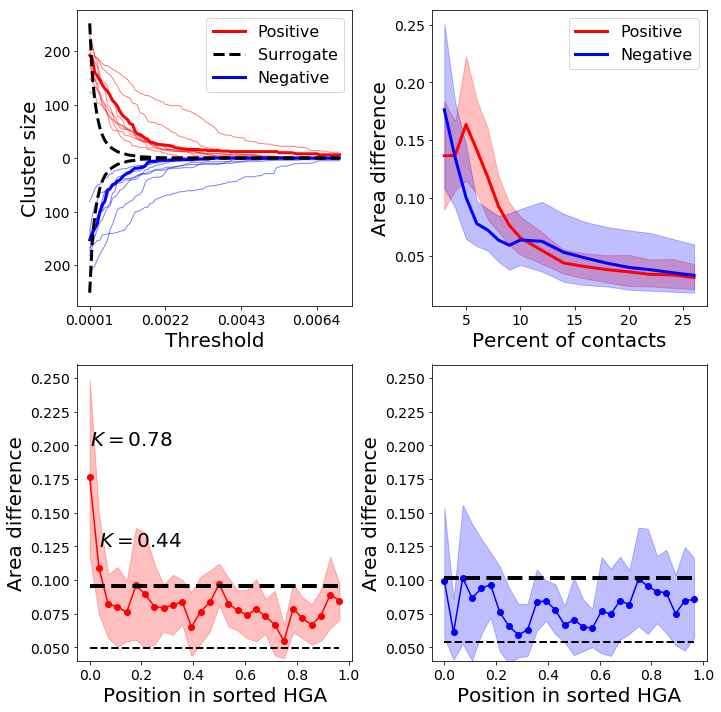

In [58]:
fig, axes = plt.subplots(figsize=(10,10), ncols=2, nrows=2)
axes = axes.flatten()

axes[0].plot(t_range, results_by_method['hga']['plus'].sum(axis=2).T, color='red', lw=1, alpha=0.5)
axes[0].plot(t_range, results_by_method['hga']['plus'][7].sum(axis=1), color='red', lw=3, label='Positive')
axes[0].plot(t_range, results_by_method['hga']['surr'].sum(axis=2).mean(axis=0), color='black', ls='--', lw=3, label='Surrogate')

axes[0].plot(t_range, -1*results_by_method['hga']['minus'].sum(axis=2).T, color='blue', lw=1, alpha=0.5)
axes[0].plot(t_range, -1*results_by_method['hga']['minus'][7].sum(axis=1), color='blue', lw=3, label='Negative')
axes[0].plot(t_range, -1*results_by_method['hga']['surr'].sum(axis=2).mean(axis=0), color='black', ls='--', lw=3)

axes[0].legend(fontsize=16)

axes[1].plot(nc_range, np.sum(pos_nc_by_top, axis=0).mean(axis=0), color='red', lw=3, label='Positive')
axes[1].fill_between(nc_range, p_nc_5, p_nc_95, color='red', alpha=0.25)
axes[1].plot(nc_range, np.sum(neg_nc_by_top, axis=0).mean(axis=0), color='blue', lw=3, label='Negative')
axes[1].fill_between(nc_range, n_nc_5, n_nc_95, color='blue', alpha=0.25)

axes[1].legend(fontsize=16)

# axes[2].plot(x_vals_shift, pos_shift_boot.mean(axis=0), color='red', label='Positive', marker='o')
# axes[2].fill_between(x_vals_shift, p_5, p_95, color='red', alpha=0.25)
# axes[2].plot(x_vals_shift, neg_shift_boot.mean(axis=0), color='blue', label='Negative', marker='o')
# axes[2].fill_between(x_vals_shift, n_5, n_95, color='blue', alpha=0.25)

# axes[2].legend(fontsize=16)

axes[2].plot(x_vals_shift, pos_shift_boot.mean(axis=0), color='red', marker='o')
axes[2].fill_between(x_vals_shift, p_5, p_95, color='red', alpha=0.25)
axes[2].plot([x_vals_shift[0], x_vals_shift[~0]], [pos_lvl.mean(), pos_lvl.mean()], color='black', ls='--', lw=4)
axes[2].plot([x_vals_shift[0], x_vals_shift[~0]], [pos_mean.mean(), pos_mean.mean()], color='black', ls='--', lw=2)

axes[3].plot(x_vals_shift, neg_shift_boot.mean(axis=0), color='blue', marker='o')
axes[3].fill_between(x_vals_shift, n_5, n_95, color='blue', alpha=0.25)
axes[3].plot([x_vals_shift[0], x_vals_shift[~0]], [neg_lvl.mean(), neg_lvl.mean()], color='black', ls='--', lw=4)
axes[3].plot([x_vals_shift[0], x_vals_shift[~0]], [neg_mean.mean(), neg_mean.mean()], color='black', ls='--', lw=2)

axes[0].set_xlabel('Threshold', fontsize=20)
axes[0].set_ylabel('Cluster size', fontsize=20)
    
axes[1].set_xlabel('Percent of contacts', fontsize=20)
axes[1].set_ylabel('Area difference', fontsize=20)

axes[2].set_xlabel('Position in sorted HGA', fontsize=20)
axes[2].set_ylabel('Area difference', fontsize=20)

axes[3].set_xlabel('Position in sorted HGA', fontsize=20)
axes[3].set_ylabel('Area difference', fontsize=20)

axes[2].set_ylim([0.04, 0.26])
axes[3].set_ylim([0.04, 0.26])

axes[0].set_xticks(t_range[::30])
axes[0].set_xticklabels(np.round(t_range, 4)[::30])

axes[0].set_yticks([-200, -100, 0, 100, 200])
axes[0].set_yticklabels([200, 100, 0, 100, 200])

axes[2].annotate(r'$K={}$'.format(np.round(pos_ratio[0], 2)), [x_vals_shift[0], 0.2], fontsize=20)
axes[2].annotate(r'$K={}$'.format(np.round(pos_ratio[1], 2)), [x_vals_shift[1], 0.125], fontsize=20)

for ax in axes:
    ax.tick_params(labelsize=14)
    

fig.tight_layout()
fig.savefig('evoked_c.pdf', dpi=300)

In [136]:
# # fig, axes = plt.subplots(figsize=(30,10), ncols=3)

# fig = plt.figure(figsize=(20,10))
# gs = fig.add_gridspec(7, 4)

# axes = [fig.add_subplot(gs[:, :2])]
# axes_pos = [fig.add_subplot(gs[i, 2]) for i in range(7)]
# axes_neg = [fig.add_subplot(gs[i, 3]) for i in range(7)]

# pos_by_subj = np.zeros((7, 6))
# neg_by_subj = np.zeros((7, 6))

# for subj_idx in range(7):
#     subj_results = list()
#     for nc in list(results_by_shift.keys()):
#         area_plus = sp.integrate.trapz(results_by_shift[nc]['plus'][subj_idx], t_range) - \
#                     sp.integrate.trapz(results_by_shift[nc]['surr'][subj_idx], t_range)

#         area_minus = sp.integrate.trapz(results_by_shift[nc]['minus'][subj_idx], t_range) - \
#                      sp.integrate.trapz(results_by_shift[nc]['surr'][subj_idx], t_range)
            
#         subj_results.append((area_plus, area_minus))
    
#     pos_areas, neg_areas = list(zip(*subj_results))
#     line = axes[0].plot(pos_areas, neg_areas, ls='--', lw=3)
#     add_arrow(line[0])
    
#     pos_by_subj[subj_idx] = pos_areas
#     neg_by_subj[subj_idx] = neg_areas
    
# axes[0].plot([0, 0.08], [0, 0.08], ls='--', color='black')

# for i in range(7):
#     axes_pos[i].plot(pos_by_subj[i])
#     axes_neg[i].plot(neg_by_subj[i])
# # imh1 = axes[1].imshow(pos_by_subj, cmap=ripples_cmap, aspect='auto', vmin=0, vmax=0.15)
# # imh2 = axes[2].imshow(neg_by_subj, cmap=ripples_cmap, aspect='auto', vmin=0, vmax=0.15)

# axes[0].set_xlabel('Positive', fontsize=20)
# axes[0].set_ylabel('Negative', fontsize=20)

# axes_pos[0].set_title('Positive', fontsize=20)
# axes_neg[0].set_title('Negative', fontsize=20)

# # fig.colorbar(imh1, ax=axes[1])
# # fig.colorbar(imh2, ax=axes[2])

# # for ax in axes[1:]:
# # #     ax.set_xticks(np.arange(4))
# # #     ax.set_xticklabels(['0-10', '10-20', '20-30', '30-40'])
# #     ax.set_xlabel('Contacts position', fontsize=20)
# #     ax.set_ylabel('Subject #', fontsize=16)
# #     ax.tick_params(labelsize=16)
    
# fig.suptitle('HGA')

In [89]:
def get_relevance_labels(arr, ref_mask):
    relevance_freqwise = arr.copy()
    
    res = list()
    res_surr = list()
    
    for i in range(relevance_freqwise.shape[0]):
        relevance_flatten = relevance_freqwise[i, ref_mask].copy()
        bins = np.percentile(relevance_flatten, (0, 20, 40, 60, 80, 100))
        
        res.append(np.digitize(relevance_freqwise[i], bins)-1)
        
        np.random.shuffle(relevance_flatten)
        relevance_freqwise[i, ref_mask] = relevance_flatten
        res_surr.append(np.digitize(relevance_freqwise[i], bins)-1)
    
    return np.array(res), np.array(res_surr)

In [7]:
def shuffle_windows(data):
    res = data.copy()
    
    n_freqs, n_contacts, _, n_windows = data.shape
    
    for freq_idx, i, j in itertools.product(range(n_freqs), range(n_contacts), range(n_contacts)):
        np.random.shuffle(res[freq_idx, i, j])
        
    return res